# Tree classification with CNN

We'll build and train a model that uses Convolutional Neural Network (CNN) architecture to classify images of four different tree species: kuusi (spruce), marjakuusi (yew), mänty (pine), and thuja. The model is trained from scratch using our own dataset, notably quite small.

### Imports

In [74]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import shutil, pathlib
import matplotlib.pyplot as plt
import keras
from keras import layers, optimizers
from keras.utils import image_dataset_from_directory

# Path to image directory
images_dir = pathlib.Path("./NewSet")

### Dataset split

The dataset is split into train, validation, and test sets (70/15/15 %) based on their respective subfolders in the directory. The original image size is 800x800 px, but they are resized to 224x224 px to decrease training time.

In [75]:
train_dataset = image_dataset_from_directory(
    images_dir / "train",
    image_size = (224, 224),
    batch_size = 32)
validation_dataset = image_dataset_from_directory(
    images_dir / "validation",
    image_size = (224, 224),
    batch_size = 32)
test_dataset = image_dataset_from_directory(
    images_dir / "test",
    image_size = (224, 224),
    batch_size = 32)

# Make sure all 4 classes are present in all 3 datasets
print(train_dataset.class_names, validation_dataset.class_names, test_dataset.class_names)

Found 416 files belonging to 4 classes.
Found 92 files belonging to 4 classes.
Found 92 files belonging to 4 classes.
['kuusi', 'marjakuusi', 'mänty', 'thuja'] ['kuusi', 'marjakuusi', 'mänty', 'thuja'] ['kuusi', 'marjakuusi', 'mänty', 'thuja']


### Data augmentation

Data augmentation is implemented to improve generalization, especially since we're using a very small dataset.

tf.Tensor([2 2 3 2 0 1 2 0 3 3 2 2 3 2 0 0 1 0 2 2 1 0 0 0 3 1 3 1 2 1 2 1], shape=(32,), dtype=int32)


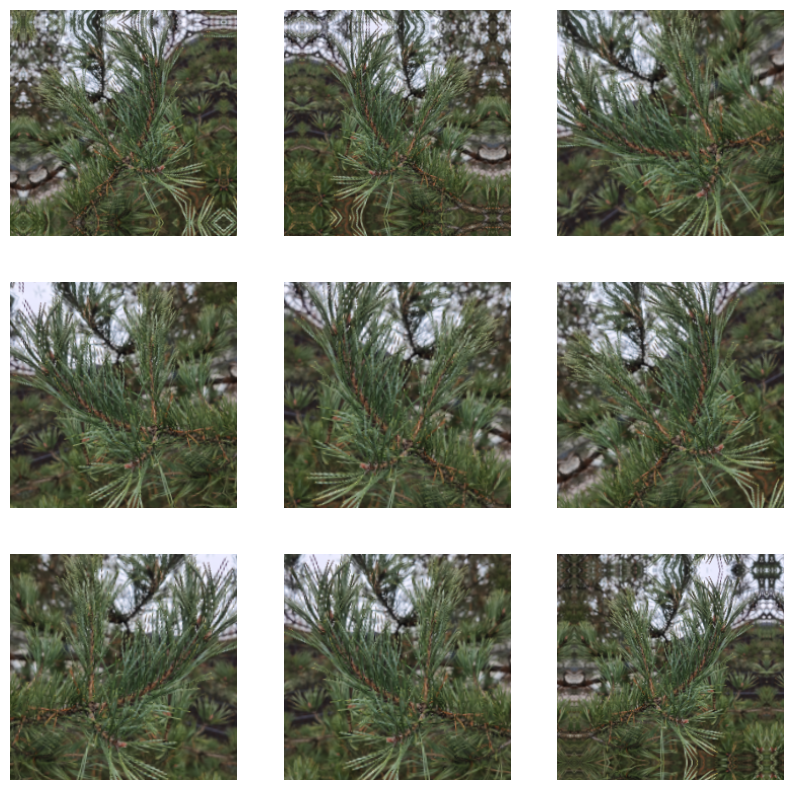

In [76]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

# Visualize a result of data augmentation
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

for images, labels in train_dataset.take(1):
    print(labels)
    break

### Defining the model

The CNN is defined to classify images of four different tree species. The process starts with data augmentation and rescaling. It includes a stack of convolutional and pooling layers, and then the extracted features are flattened and passed through a dropout layer and a dense output layer with a softmax activation to produce probabilities for four differenct classes.

In [77]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1.0/255)(x)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x) # smaller dropout to eliminate fluctuation in val loss/acc

outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_8 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 10, 10, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │       102,404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,080,900 (4.12 MB)

 Trainable params: 1,080,900 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

### Compiling the model

The CNN is compiled using the Adam optimizer with a learning rate of 0.0003 due to the small amount of data in each batch. A lower learning rate ensures stability in training the model.

In [78]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer = optimizers.Adam(learning_rate=0.0003),
    metrics=["accuracy"]
)

# Print a single batch to confirm the correct shape and labels of the images
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 224, 224, 3)
labels batch shape: (32,)


### Training the model

The CNN is trained on the training dataset for 20 epochs, while evaluating its performance using the validation set each epoch. A ModelCheckpoint callback is used to automatically save the version of the model that achieves the lowest validation loss for later testing.

In [79]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch_with_augmentation.keras",
    save_best_only=True,
    monitor="val_loss"
)]

history = model.fit(
    train_dataset,
    epochs = 20,
    validation_data=validation_dataset,
    callbacks = callbacks
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.3341 - loss: 1.3328 - val_accuracy: 0.5435 - val_loss: 1.0689
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.6010 - loss: 0.9055 - val_accuracy: 0.3696 - val_loss: 1.7122
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.6827 - loss: 0.7380 - val_accuracy: 0.6522 - val_loss: 0.8522
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.7524 - loss: 0.6561 - val_accuracy: 0.6957 - val_loss: 0.6958
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8029 - loss: 0.5709 - val_accuracy: 0.6957 - val_loss: 0.7021
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.7668 - loss: 0.5406 - val_accuracy: 0.6304 - val_loss: 1.2348
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.7933 - loss: 0.4927 - val_accuracy: 0.6957 - val_loss: 0.8400
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.8005 - loss: 0.4502 - val_accuracy: 0.7174 - v

### Visualizing results

The training and validation accuracy and loss over the epochs are visualized to assess the model’s learning progress.

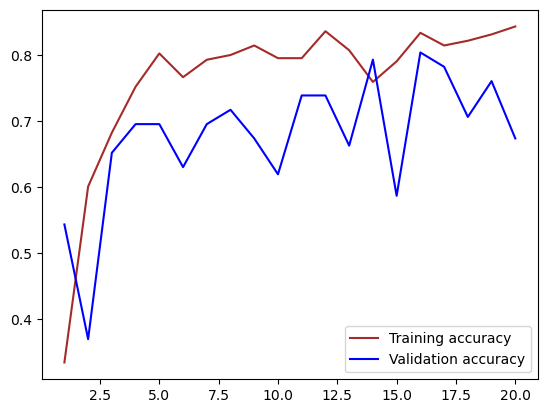

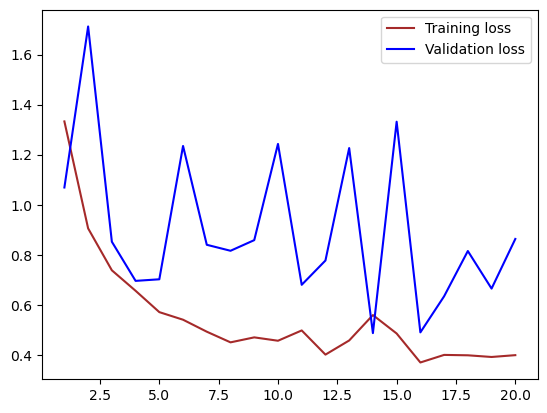

In [80]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = list(range(1, len(accuracy)+1))

plt.plot(epochs, accuracy, label="Training accuracy", color="brown")
plt.plot(epochs, val_accuracy, label="Validation accuracy", color="blue")
plt.legend()
plt.figure()
plt.plot(epochs, loss, label="Training loss", color="brown")
plt.plot(epochs, val_loss, label="Validation loss", color="blue")
plt.legend()
plt.show()

The training accuracy steadily increases and reaches above 80%, indicating that the model is learning the training data well. However, the validation accuracy fluctuates a lot between epochs, likely due to the small size of the validation set. Similarly, the training loss decreases smoothly, while the validation shows large spikes, which points to the same issue. Overall, the model is learning meaningful features, but the validation metrics are noisy, albeit unsurprisingly.

### Testing the model

The best performing model that was saved using a callback is evaluated using the test set to measure its true accuracy.

In [81]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9022 - loss: 0.3158
Test accuracy: 0.902


The accuracy seems to be quite good considering the model was built from scratch on such a small dataset instead of using a pre-trained one.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Found 9 mistakes.


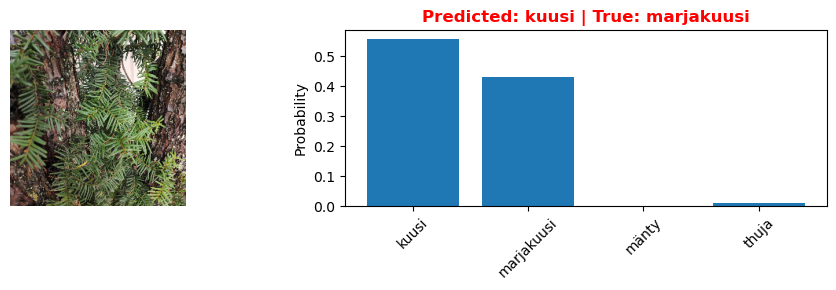

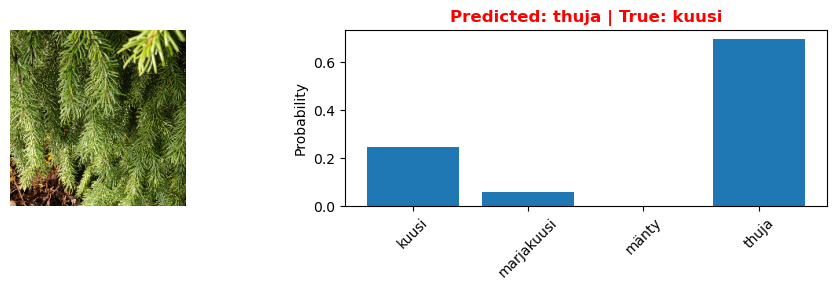

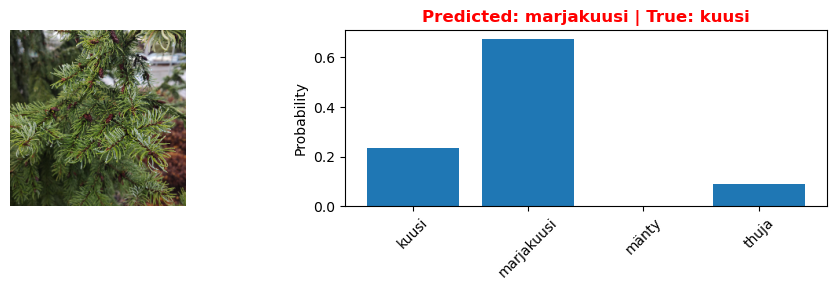

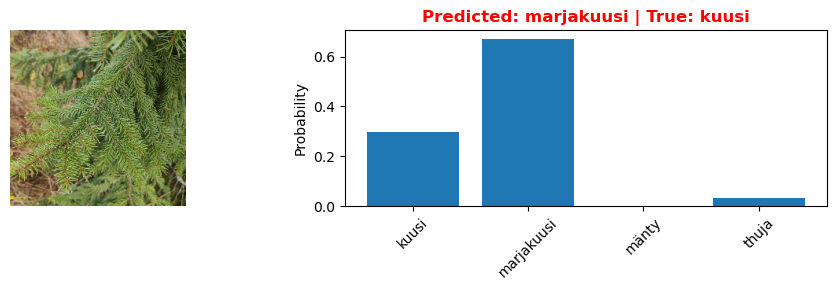

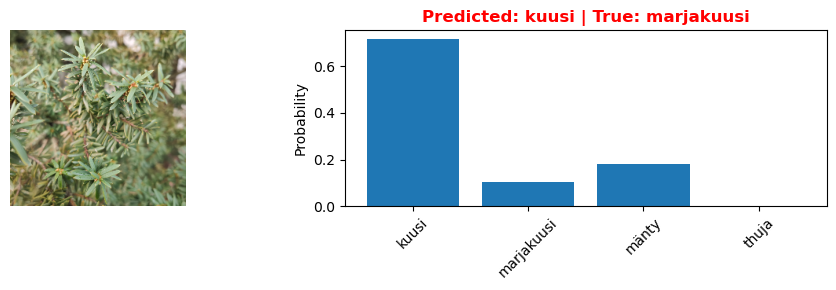

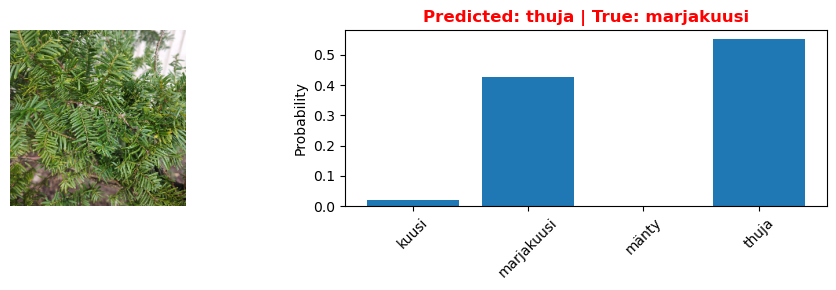

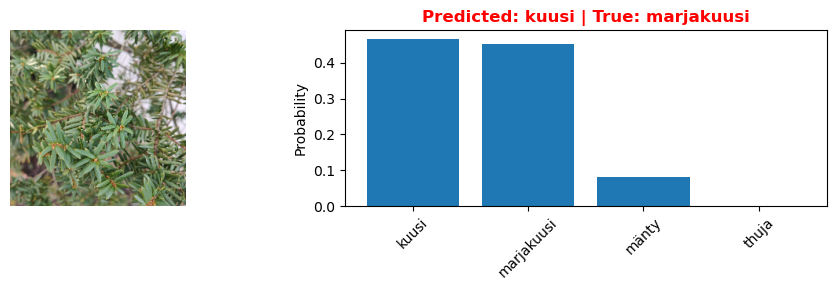

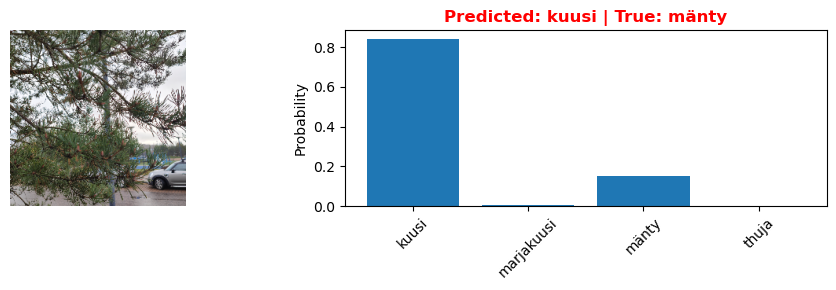

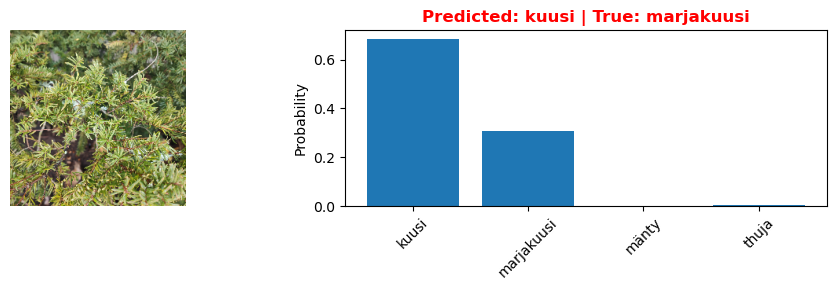

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Collect all test data and labels
# We extract the data manually so we can index it to show specific images
x_test = []
y_true = []

for images, labels in test_dataset:
    x_test.append(images.numpy())
    y_true.append(labels.numpy())

x_test = np.concatenate(x_test, axis=0)
y_true = np.concatenate(y_true, axis=0)

# 2. Get predictions
# IMPORTANT: In this notebook, your model variable is 'test_model'
y_pred_probs = test_model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
class_names = test_dataset.class_names

# 3. Find ONLY mistakes
mistake_indices = np.where(y_pred_classes != y_true)[0]

if len(mistake_indices) == 0:
    print("\nSUCCESS: The model made 0 mistakes! (Accuracy is 100%)")
else:
    print(f"\nFound {len(mistake_indices)} mistakes.")

    # Show only the mistakes
    for k in mistake_indices:
        plt.figure(figsize=(10, 3))

        # Image
        plt.subplot(1, 2, 1)
        plt.imshow(x_test[k].astype("uint8"))
        plt.axis('off')

        # Bar chart of probabilities
        plt.subplot(1, 2, 2)
        probs = y_pred_probs[k]
        plt.bar(np.arange(len(class_names)), probs)
        plt.xticks(np.arange(len(class_names)), class_names, rotation=45)

        pred_label = class_names[y_pred_classes[k]]
        true_label = class_names[y_true[k]]

        # Title is RED for mistakes
        plt.ylabel("Probability")
        plt.title(f"Predicted: {pred_label} | True: {true_label}", color='red', fontweight='bold')

        plt.tight_layout()
        plt.show()
